In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '../')
import my_utils as myf
import importlib
importlib.reload(myf)
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 12})
xr.set_options(keep_attrs=True)

In [2]:
da = pd.read_csv(myf.processed_dir+'/fwdata/mass_change_antarctica.csv',sep='\t')

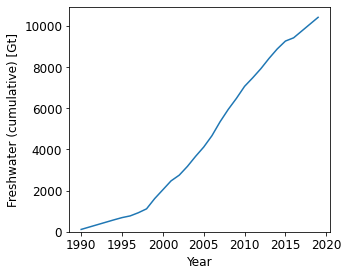

In [3]:
fig = plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 12})
ax = plt.subplot(1,1,1)
ax.plot(da['Year'], np.cumsum(da['Gt/yr']))
ax.set_xlabel('Year')
ax.set_ylabel('Freshwater (cumulative) [Gt]')
ax.set_ylim(bottom=0)
plt.tight_layout()
fig.savefig('../figs/figS2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [8]:
y1, y2 = 1990, 2021

In [9]:
runmap = pd.read_csv('../e2.1runmap.csv',sep=',')
allens = runmap['names'].values
allens = [f for f in allens if 'r202i1p1f4' not in f]  # don't forget to remove!!!

In [14]:
listds = []
for f in allens[:]:
    listds_i = []
    for var in ['sia','tos','sam']:
        listds_i.append(xr.open_mfdataset(myf.processed_dir+'timeseries/'+var+'/*'+f+'*.nc'))
    ds_i = xr.merge(listds_i).load()
    ds_i = ds_i.drop('type')
    listds.append(ds_i)
ds = xr.concat(listds,dim='names').sel(time=slice(str(y1),str(y2))).sel(region='50-65S').groupby('time.year').mean(dim='time')
ds = ds.drop(['lat_bnds','lon_bnds'])

In [15]:
ens_ctrl = [f for f in allens if 'f2' in f or 'f1' in f]
ens_mw = [f for f in allens if 'f4' in f]
ens_wind = [f for f in allens if 'f5' in f]
ens_windmw = [f for f in allens if 'f6' in f]

for n, myens in enumerate([ens_ctrl,ens_mw, ens_wind, ens_windmw]):
    ds_add = ds.sel(names=myens).mean(dim='names')
    ds_add['names'] = ['CTRLmean','MWmean','WINDmean','WIND&MWmean'][n]
    ds_add = ds_add.set_coords('names')
    ds = xr.concat([ds,ds_add],dim='names')

In [18]:
diff = ds.sel(names='WIND&MWmean') - ds.sel(names='WINDmean')
winddiff = ds.sel(names='WINDmean') - ds.sel(names='CTRLmean')
winddiff2 = ds.sel(names='WIND&MWmean') - ds.sel(names='MWmean')

At a 2 year lag, SIA change for 1000 Gt freshwater is 0.62 million km^2


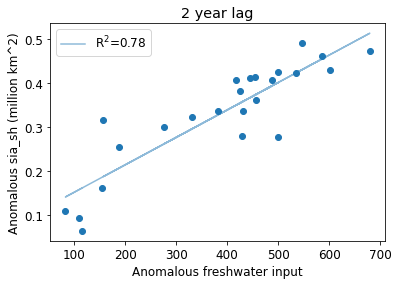

In [20]:
for var in ['sia_sh']:
    y = diff[var].sel(year=slice(1994+2,2019))
    x = xr.DataArray(da['Gt/yr'].values[4:-2],dims=('year'),coords={'year':y.year})
    fig, ax = plt.subplots(1)
    ax.scatter(x,y)
    ax.set_title('2 year lag')
    slope, intercept, r_value, p_value, std_err = myf.linregress(x,y,dim='year')
    ax.plot(x,slope*x+intercept,alpha=.5,label='R$^2$={:.2f}'.format(r_value.values**2))
    print('At a 2 year lag, SIA change for 1000 Gt freshwater is {:.2f} million km^2'.format(1000.*slope.values))
    ax.set_xlabel('Anomalous freshwater input')
    ax.set_ylabel('Anomalous '+var+' ('+ds[var].attrs['units']+')')
    plt.legend()
    plt.show()
    plt.close()

At a 4 year lag, SST change for 1000 Gt freshwater is -0.143 K


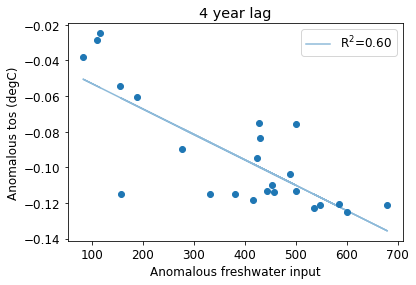

In [22]:
for var in ['tos']:
    y = diff[var].sel(year=slice(1994+4,2021))
    x = xr.DataArray(da['Gt/yr'].values[4:-2],dims=('year'),coords={'year':y.year})
    fig, ax = plt.subplots(1)
    ax.scatter(x,y)
    ax.set_title('4 year lag')
    slope, intercept, r_value, p_value, std_err = myf.linregress(x,y,dim='year')
    ax.plot(x,slope*x+intercept,alpha=.5,label='R$^2$={:.2f}'.format(r_value.values**2))
    ax.set_xlabel('Anomalous freshwater input')
    ax.set_ylabel('Anomalous '+var+' ('+ds[var].attrs['units']+')')
    print('At a 4 year lag, SST change for 1000 Gt freshwater is {:.3f} K'.format(1000.*slope.values))
    plt.legend()
    plt.show()
    plt.close()

Max correlation for sia_sh 0.92
Max correlation for tos 0.90


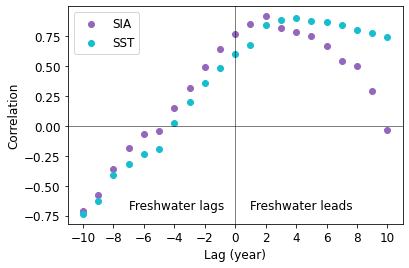

In [24]:
max_lag = 10
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1)
for v, var in enumerate(['sia_sh','tos']):
    y = diff[var].sel(year=slice(1994,2017))
    x = xr.DataArray(da['Gt/yr'].values[4:-2],dims=('year'),coords={'year':y.year})
    corr, pval = myf.pearson(x,y ,dim='year')
    mydict = {}
    mydict[0] = corr
    for l in np.arange(1,max_lag+1):
        corr, pval = myf.pearson(x.isel(year=slice(0,-l)).values,y.isel(year=slice(l,None)).values,dim='year')
        mydict[l] = corr
        corr, pval = myf.pearson(y.isel(year=slice(0,-l)).values,x.isel(year=slice(l,None)).values,dim='year')
        mydict[-l] = corr

    for l in np.arange(-max_lag, max_lag+1, 1):
        factor = 1
        if v==1:
            factor = -1
        ax.scatter(l,factor*mydict[l],c=['tab:purple','tab:cyan'][v],label=['SIA','SST'][v])
    print('Max correlation for '+var+' {:.2f}'.format( max([factor*mydict[l] for l in mydict])))
ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (year)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xticks(np.arange(-10,12,2))
ax.axhline(y=0,c='k',linewidth=.5)
ax.axvline(x=0,c='k',linewidth=.5)
ax.text(-7,-.7,'Freshwater lags')
ax.text(1,-.7,'Freshwater leads')
fig.savefig('../figs/figS7.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [34]:

myds = diff.sel(year=slice(1990,2021))
slope, intercept, r_value, p_value, std_err = myf.linregress(myds.year, myds,dim='year')
print('Impact of freshwater, SIA trend = {:.2f} \pm {:.2f}  million km^2/decade'.format(10.*slope.sia_sh.values,10.*std_err.sia_sh.values))
print('Impact of freshwater, SST trend = {:.2f} \pm {:.3f}  million km^2/decade'.format(10.*slope.tos.values,10.*std_err.tos.values))

myds = winddiff.sel(year=slice(1990,2021))
slope, intercept, r_value, p_value, std_err = myf.linregress(myds.year,myds,dim='year')
print('Impact of winds, SIA trend = {:.2f} \pm {:.2f}  million km^2/decade'.format(10.*slope.sia_sh.values,10.*std_err.sia_sh.values))
print('Impact of winds, SIA trend = {:.2f} \pm {:.2f}  million km^2/decade'.format(10.*slope.tos.values,10.*std_err.tos.values))

myds = winddiff2.sel(year=slice(1990,2021))
slope, intercept, r_value, p_value, std_err = myf.linregress(myds.year,myds,dim='year')
print('Impact of winds 2, SIA trend = {:.2f} \pm {:.2f}  million km^2/decade'.format(10.*slope.sia_sh.values,10.*std_err.sia_sh.values))
print('Impact of winds 2, SIA trend = {:.2f} \pm {:.2f}  million km^2/decade'.format(10.*slope.tos.values,10.*std_err.tos.values))



Impact of freshwater, SIA trend = 0.13 \pm 0.02  million km^2/decade
Impact of freshwater, SST trend = -0.04 \pm 0.003  million km^2/decade
Impact of winds, SIA trend = 0.41 \pm 0.06  million km^2/decade
Impact of winds, SIA trend = -0.04 \pm 0.02  million km^2/decade
Impact of winds 2, SIA trend = 0.36 \pm 0.07  million km^2/decade
Impact of winds 2, SIA trend = -0.01 \pm 0.02  million km^2/decade
